In [16]:
import pandas as pd
import numpy as np
import os
import csv
import glob
import re
import matplotlib.pyplot as plt

In [377]:
scenario='val_de_bagnes_41_climate_contemporary_pv_roof_2025'
folder_path = '../Output/'+scenario
#val_de_bagnes_41_climate_rcp85_pv_roof_walls_2050
#val_de_bagnes_41_climate_rcp85_pv_roof_2050
#val_de_bagnes_41_climate_rcp26_pv_roof_walls_2050
#val_de_bagnes_41_climate_rcp26_pv_roof_2050

#val_de_bagnes_41_climate_contemporary_pv_roof_2025

In [ ]:
import os
import re
import glob
import pandas as pd
from pathlib import Path

pattern = os.path.join(folder_path, 'df_*(Building-*)_NMC_0100_*_*_SFH100.csv')
csv_files = glob.glob(pattern)

# Mapping from configuration binary code to its label
mapping_str = {
    '0100': 'HP',
    '0101': 'HP & DHW',
    '0110': 'HP & SH',
    '0111': 'HP & SH & DHW',
    '1100': 'HP & BATT',
    '1101': 'HP & DHW & BATT',
    '1110': 'HP & SH & BATT',
    '1111': 'HP & SH & DHW & BATT'
}

# Define keys to accumulate
keys = ['E_PV', 'E_PV_load', 'E_PV_batt', 'E_PV_bu',
        'E_PV_budhw', 'E_PV_hp', 'E_PV_hpdhw',  'E_batt_hp', 'E_batt_hpdhw', 'E_batt_budhw', 'E_batt_bu',
        'E_PV_batt_EV', 'E_EV_trip', 'E_grid_load','E_batt_load',
        'E_demand', 'Req_kWh','E_hp']

# Dictionaries to accumulate sums
# Building_data is keyed by (building_id, configuration)
building_data = {}
# Config_data is keyed by configuration (aggregated over all buildings)
config_data = {}

for f in csv_files:
    filename = os.path.basename(f)
    match = re.search(r'df_((?:\d+\(Building-[\d\-]+-[\dA-Z]+\)))_NMC_0100_([0-9]+)_([0-9]+)_SFH100', filename)
    if not match:
        continue
    building_id = match.group(1)
    configuration = match.group(3)  # e.g., '0100', '1100', etc.
    df = pd.read_csv(f)
    # Update per building-configuration data
    key_bld = (building_id, configuration)
    if key_bld not in building_data:
        building_data[key_bld] = {k: 0 for k in keys}
    for k in keys:
        if k in df.columns:
            building_data[key_bld][k] += df[k].sum()
    
    # Update per configuration aggregated data
    if configuration not in config_data:
        config_data[configuration] = {k: 0 for k in keys}
    for k in keys:
        if k in df.columns:
            config_data[configuration][k] += df[k].sum()

# Helper to compute KPIs from a data dictionary of energy flows
def compute_kpis(data):
    if data['E_PV'] > 0:
        
        TSC = (data['E_PV_load'] + data['E_PV_batt'] + data['E_PV_bu'] +
               data['E_PV_budhw'] + data['E_PV_hp'] + data['E_PV_hpdhw'] +
               data['E_PV_batt_EV']) / data['E_PV'] * 100
        DSC = (data['E_PV_load'] + data['E_PV_bu'] + data['E_PV_budhw'] +
               data['E_PV_hp'] + data['E_PV_hpdhw'] + data['E_PV_batt_EV']) / data['E_PV'] * 100
        ISC = data['E_PV_batt'] / data['E_PV'] * 100        
    else:
        TSC = DSC = ISC = 0
    denom = data['E_EV_trip'] + data['E_demand'] + data['E_hp']
    TSS = (data['E_PV_load'] + data['E_batt_load'] + data['E_PV_bu'] +
               data['E_PV_budhw'] + data['E_PV_hp'] + data['E_PV_hpdhw'] + 
               data['E_batt_hp'] + data['E_batt_hpdhw'] + data['E_batt_budhw'] + data['E_batt_bu'] +
               data['E_PV_batt_EV']) / denom * 100 if denom > 0 else 0

    return (round(TSC,1), round(DSC,1), round(ISC,1), round(TSS,1))

rows = []

# Create individual building rows (each differentiated by configuration)
for (bld, conf) in building_data:
    data = building_data[(bld, conf)]
    TSC, DSC, ISC, TSS = compute_kpis(data)
    rows.append({
        'Building': bld,
        'Configuration': mapping_str.get(conf, conf),
        'TSC [%]': TSC,
        'DSC [%]': DSC,
        'ISC [%]': ISC,
        'TSS [%]': TSS,
        'Demand_electric [kWh]': round(data['E_demand'] + data['E_EV_trip'], 1),
        'Demand_thermal [kWh]': round(data['Req_kWh'], 1),
        'Generation [kWh]': round(data['E_PV'], 1)
    })

# Create aggregated rows per configuration (all buildings combined)
for conf in config_data:
    data = config_data[conf]
    TSC, DSC, ISC, TSS = compute_kpis(data)
    rows.append({
        'Building': 'Aggregated',
        'Configuration': mapping_str.get(conf, conf),
        'TSC [%]': TSC,
        'DSC [%]': DSC,
        'ISC [%]': ISC,
        'TSS [%]': TSS,
        'Demand_electric [kWh]': round(data['E_demand'] + data['E_EV_trip'], 1),
        'Demand_thermal [kWh]': round(data['Req_kWh'], 1),
        'Generation [kWh]': round(data['E_PV'], 1)
    })

output = pd.DataFrame(rows)
print(output)


                                    Building Configuration  TSC [%]  DSC [%]  \
0      26930(Building-902138-CH895237183088)            HP     30.1     30.1   
1      26930(Building-902138-CH895237183088)     HP & BATT     35.6     20.8   
2      26931(Building-902142-CH963752308786)            HP     42.1     42.1   
3      26931(Building-902142-CH963752308786)     HP & BATT     47.4     34.0   
4   26932(Building-190183183-CH113098523737)            HP     24.4     24.4   
5   26932(Building-190183183-CH113098523737)     HP & BATT     29.5     15.6   
6      26933(Building-902139-CH503730975261)            HP     31.4     31.4   
7      26933(Building-902139-CH503730975261)     HP & BATT     37.4     21.3   
8      26934(Building-902141-CH513082523745)            HP     32.5     32.5   
9      26934(Building-902141-CH513082523745)     HP & BATT     37.9     23.7   
10                                Aggregated            HP     29.8     29.8   
11                                Aggreg

In [379]:
output

,Building,Configuration,TSC [%],DSC [%],ISC [%],TSS [%],Demand_electric [kWh],Demand_thermal [kWh],Generation [kWh]
0,26930(Building-902138-CH895237183088),HP,30.1,30.1,0.0,42.1,7969.2,15277.4,17367.9
1,26930(Building-902138-CH895237183088),HP & BATT,35.6,20.8,14.8,47.2,7969.2,15277.4,17367.9
2,26931(Building-902142-CH963752308786),HP,42.1,42.1,0.0,36.7,5210.5,8691.6,6696.1
3,26931(Building-902142-CH963752308786),HP & BATT,47.4,34.0,13.4,39.8,5210.5,8691.6,6696.1
4,26932(Building-190183183-CH113098523737),HP,24.4,24.4,0.0,44.6,9806.6,19598.0,28405.3
5,26932(Building-190183183-CH113098523737),HP & BATT,29.5,15.6,13.9,50.6,9806.6,19598.0,28405.3
6,26933(Building-902139-CH503730975261),HP,31.4,31.4,0.0,40.5,10725.0,21899.7,22162.5
7,26933(Building-902139-CH503730975261),HP & BATT,37.4,21.3,16.1,45.5,10725.0,21899.7,22162.5
8,26934(Building-902141-CH513082523745),HP,32.5,32.5,0.0,41.3,7048.7,12283.3,13441.8
9,26934(Building-902141-CH513082523745),HP & BATT,37.9,23.7,14.2,45.9,7048.7,12283.3,13441.8


In [380]:
output['scenario']=scenario

In [381]:
output.to_csv('val_de_bagnes_41.csv', mode='a', header=False, index=False)

In [382]:
output=pd.read_csv('val_de_bagnes_41.csv',header=None,index_col=None,names=['Building',	'Configuration',	'TSC [%]',	'DSC [%]',	'ISC [%]',	'TSS [%]',	'Demand_electric [kWh]',	'Demand_thermal [kWh]',	'Generation [kWh]','Scenario'])

In [383]:
output.head(50)

,Building,Configuration,TSC [%],DSC [%],ISC [%],TSS [%],Demand_electric [kWh],Demand_thermal [kWh],Generation [kWh],Scenario
0,26930(Building-902138-CH895237183088),HP,17.6,17.6,0.0,60.0,7969.2,12250.8,39477.9,val_de_bagnes_41_climate_rcp85_pv_roof_walls_2050
1,26930(Building-902138-CH895237183088),HP & BATT,20.5,10.0,10.5,65.4,7969.2,12250.8,39477.9,val_de_bagnes_41_climate_rcp85_pv_roof_walls_2050
2,26931(Building-902142-CH963752308786),HP,20.4,20.4,0.0,62.4,5210.5,6985.6,22145.0,val_de_bagnes_41_climate_rcp85_pv_roof_walls_2050
3,26931(Building-902142-CH963752308786),HP & BATT,23.4,13.7,9.7,67.7,5210.5,6985.6,22145.0,val_de_bagnes_41_climate_rcp85_pv_roof_walls_2050
4,26932(Building-190183183-CH113098523737),HP,16.6,16.6,0.0,57.4,9806.6,15817.5,49770.8,val_de_bagnes_41_climate_rcp85_pv_roof_walls_2050
5,26932(Building-190183183-CH113098523737),HP & BATT,20.0,9.6,10.4,63.9,9806.6,15817.5,49770.8,val_de_bagnes_41_climate_rcp85_pv_roof_walls_2050
6,26933(Building-902139-CH503730975261),HP,17.2,17.2,0.0,59.3,10725.0,17575.5,54758.4,val_de_bagnes_41_climate_rcp85_pv_roof_walls_2050
7,26933(Building-902139-CH503730975261),HP & BATT,20.5,10.1,10.4,65.6,10725.0,17575.5,54758.4,val_de_bagnes_41_climate_rcp85_pv_roof_walls_2050
8,26934(Building-902141-CH513082523745),HP,19.2,19.2,0.0,58.5,7048.7,9894.3,30338.2,val_de_bagnes_41_climate_rcp85_pv_roof_walls_2050
9,26934(Building-902141-CH513082523745),HP & BATT,22.4,11.9,10.5,64.3,7048.7,9894.3,30338.2,val_de_bagnes_41_climate_rcp85_pv_roof_walls_2050


In [384]:
hp_table = output[output['Configuration'] == 'HP']
hp_batt_table = output[output['Configuration'] == 'HP & BATT']
hp_table.to_csv("HP_Configuration_Table.csv", index=False)
hp_batt_table.to_csv("HP_BATT_Configuration_Table.csv", index=False)

In [277]:
output.Configuration

0            HP
1     HP & BATT
2            HP
3     HP & BATT
4            HP
5     HP & BATT
6            HP
7     HP & BATT
8            HP
9     HP & BATT
10           HP
11    HP & BATT
12           HP
13    HP & BATT
14           HP
15    HP & BATT
16           HP
17    HP & BATT
18           HP
19    HP & BATT
20           HP
21    HP & BATT
22           HP
23    HP & BATT
24           HP
25    HP & BATT
26           HP
27    HP & BATT
28           HP
29    HP & BATT
30           HP
31    HP & BATT
32           HP
33    HP & BATT
34           HP
35    HP & BATT
Name: Configuration, dtype: object

In [236]:

# Pattern to match files
pattern = os.path.join(folder_path, 'df_*(Building-*)_NMC_0100_*_*_SFH100.csv')

# List of matched files
csv_files = glob.glob(pattern)

# Read all matching CSV files into a list of DataFrames
dataframes = [pd.read_csv(file) for file in csv_files]

# Optionally, concatenate into a single DataFrame
# combined_df = pd.concat(dataframes, ignore_index=True)
rows = []

# Example: print names of matched files
for f in csv_files:
    filename = os.path.basename(f)
    match = re.search(r'df_((?:\d+\(Building-[\d\-]+-[\dA-Z]+\)))_NMC_0100_([0-9]+)_([0-9]+)_SFH100', filename)
    if match:
        building_id = match.group(1)
        configuration = match.group(3)
        

    df = pd.read_csv(f)
    print(df.E_EV_trip.sum())
    TSC = (df['E_PV_load'] + df['E_PV_batt'] + df['E_PV_bu'] + df['E_PV_budhw'] + 
                    df['E_PV_hp'] + df['E_PV_hpdhw'] + df['E_PV_batt_EV']).sum() / df['E_PV'].sum() * 100

    DSC = (df['E_PV_load'] + df['E_PV_bu'] + df['E_PV_budhw'] + df['E_PV_hp'] + 
            df['E_PV_hpdhw'] + df['E_PV_batt_EV']).sum() / df['E_PV'].sum() * 100

    ISC = df['E_PV_batt'].sum() / df['E_PV'].sum() * 100
    TSS=(df['E_PV_load'] + df['E_PV_batt'] + df['E_PV_bu'] + df['E_PV_budhw'] + 
                    df['E_PV_hp'] + df['E_PV_hpdhw'] + df['E_PV_batt_EV']).sum() /(df.E_EV_trip+df.E_demand+df.E_hp).sum()*100#[%]
    mapping_str = {
    '0100': 'HP',
    '0101': 'HP & DHW',
    '0110': 'HP & SH',
    '0111': 'HP & SH & DHW',
    '1100': 'HP & BATT',
    '1101': 'HP & DHW & BATT',
    '1110': 'HP & SH & BATT',
    '1111': 'HP & SH & DHW & BATT' 
    }


    rows.append({
        'Building': building_id,
        'Configuration': mapping_str[configuration],
        'TSC [%]': TSC.round(1),
        'DSC [%]': DSC.round(1),
        'ISC [%]': ISC.round(1),
        'TSS [%]': TSS.round(1),
        'Demand_electric [kWh]' : df.E_demand.sum().round(1)+df.E_EV_trip.sum().round(1),
        'Demand_thermal [kWh]' : df.Req_kWh.sum().round(1),#missing DHW
        'Generation [kWh]' : df.E_PV.sum().round(1)
    })
output = pd.DataFrame(rows)




3374.2234000000003
3374.2234000000003
3374.2234000000003
3374.2234000000003
3374.2234000000003
3374.2234000000003
3374.2234000000003
3374.2234000000003
3374.2234000000003
3374.2234000000003


In [237]:
df.E_EV_trip.sum()

np.float64(3374.2234000000003)

In [238]:
output

,Building,Configuration,TSC [%],DSC [%],ISC [%],TSS [%],Demand_electric [kWh],Demand_thermal [kWh],Generation [kWh]
0,26930(Building-902138-CH895237183088),HP,28.5,28.5,0.0,44.3,7969.2,12279.6,17919.3
1,26930(Building-902138-CH895237183088),HP & BATT,33.9,20.3,13.6,52.5,7969.2,12279.6,17919.3
2,26931(Building-902142-CH963752308786),HP,40.9,40.9,0.0,39.1,5210.5,6994.9,6905.8
3,26931(Building-902142-CH963752308786),HP & BATT,45.9,33.7,12.2,43.8,5210.5,6994.9,6905.8
4,26932(Building-190183183-CH113098523737),HP,23.1,23.1,0.0,46.9,9806.6,15876.4,29275.6
5,26932(Building-190183183-CH113098523737),HP & BATT,27.8,15.1,12.7,56.3,9806.6,15876.4,29275.6
6,26933(Building-902139-CH503730975261),HP,29.8,29.8,0.0,42.8,10724.9,17622.4,22850.5
7,26933(Building-902139-CH503730975261),HP & BATT,35.6,20.7,14.9,51.0,10724.9,17622.4,22850.5
8,26934(Building-902141-CH513082523745),HP,31.1,31.1,0.0,43.4,7048.7,9916.1,13826.5
9,26934(Building-902141-CH513082523745),HP & BATT,36.1,23.1,13.0,50.4,7048.7,9916.1,13826.5


In [202]:
df=pd.read_csv('../Output/old/df_26934(Building-902141-CH513082523745)_NMC_0100_13_0100_SFH100.csv')

In [203]:
df.Q_ts_sh.sum()

np.float64(0.0)

In [204]:
df.Req_kWh.sum()

np.float64(12435.974)

In [205]:
df.E_hp.sum()

np.float64(3541.460201147035)

In [211]:
df.columns

Index(['index', 'Bool_char', 'Bool_char_EV', 'Bool_cons', 'Bool_dis',
       'Bool_dis_EV', 'Bool_hp', 'Bool_hpdhw', 'Bool_inj', 'E_PV_batt',
       'E_PV_batt_EV', 'E_PV_bu', 'E_PV_budhw', 'E_PV_curt', 'E_PV_grid',
       'E_PV_hp', 'E_PV_hpdhw', 'E_PV_load', 'E_batt_EV_grid',
       'E_batt_EV_load', 'E_batt_bu', 'E_batt_budhw', 'E_batt_hp',
       'E_batt_hpdhw', 'E_batt_load', 'E_bu', 'E_budhw', 'E_char', 'E_char_EV',
       'E_char_away', 'E_cons', 'E_dis', 'E_dis_EV', 'E_grid_batt',
       'E_grid_batt_EV', 'E_grid_bu', 'E_grid_budhw', 'E_grid_hp',
       'E_grid_hpdhw', 'E_grid_load', 'E_hp', 'E_hpdhw', 'E_loss_Batt',
       'E_loss_Batt_EV', 'E_loss_EV', 'E_loss_conv', 'E_loss_inv',
       'E_loss_inv_PV', 'E_loss_inv_batt', 'E_loss_inv_grid', 'Q_dhwst_hd',
       'Q_hp_sh', 'Q_hp_ts', 'Q_loss_dhwst', 'Q_loss_ts', 'Q_ts', 'Q_ts_delta',
       'Q_ts_sh', 'SOC', 'SOC_EV', 'T_dhwst', 'T_ts', 'E_demand', 'E_PV',
       'Export_price', 'price', 'Inv_P', 'Conv_P', 'Req_kWh', 'Req_kWh

<Axes: >

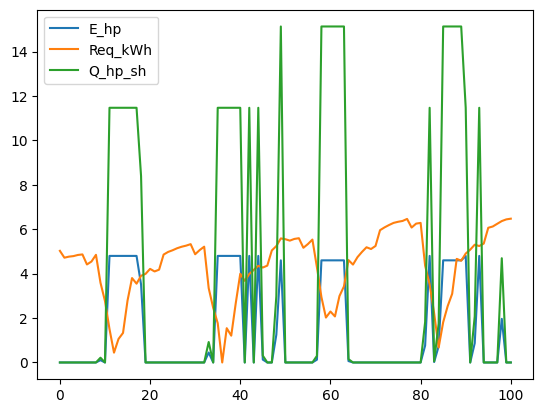

In [213]:
df.loc[0:100,['E_hp','Req_kWh','Q_hp_sh']].plot()


In [163]:
TSS=(df['E_PV_load'] + df['E_PV_batt'] + df['E_PV_bu'] + df['E_PV_budhw'] + 
                    df['E_PV_hp'] + df['E_PV_hpdhw'] + df['E_PV_batt_EV']).sum() /(df.E_EV_trip+df.E_demand+df.E_hp).sum()*100#[%]

In [164]:
TSS

np.float64(46.161409190296176)

In [165]:
df2=pd.read_csv('../Output/df_26934(Building-902141-CH513082523745)_NMC_0100_13_1100_SFH100.csv')

In [166]:
df2.sum()

index           2017-01-01 00:00:00+01:002017-01-01 01:00:00+0...
Bool_char                                                  5766.0
Bool_char_EV                                               4765.0
Bool_cons                                                  5506.0
Bool_dis                                                   2994.0
                                      ...                        
T_aux_supply                                       2747597.765963
COP_tank                                               40620.5675
COP_SH                                                 42021.5875
COP_DHW                                                  23692.08
E_EV_trip                                                610.5824
Length: 79, dtype: object

In [171]:
df2.SOC.describe()

count    8760.000000
mean        1.285261
std         2.381675
min         0.000000
25%         0.000000
50%         0.000000
75%         1.876277
max        12.984116
Name: SOC, dtype: float64

<Axes: >

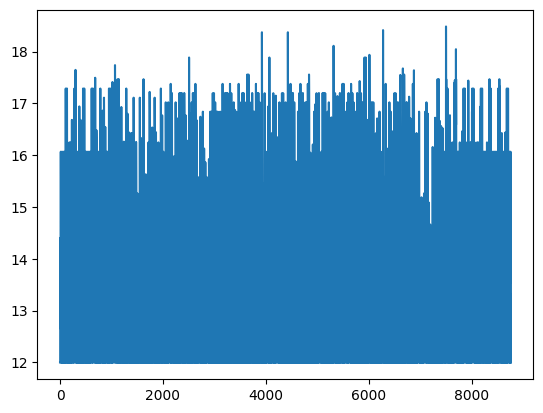

In [172]:
df2.SOC_EV.plot()

<Axes: >

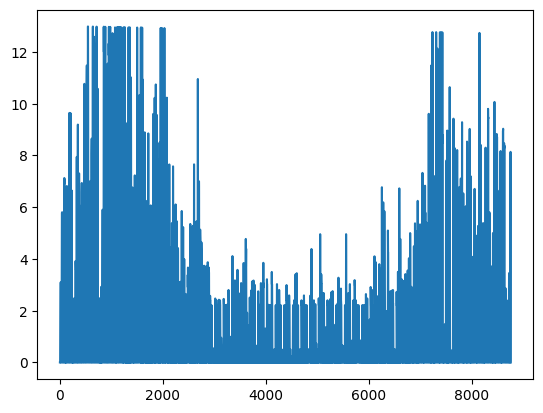

In [173]:
df2.SOC.plot()

<Axes: >

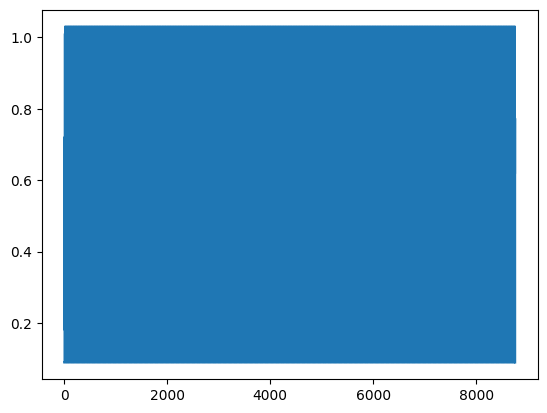

In [176]:
df2.E_demand.plot()

<Axes: >

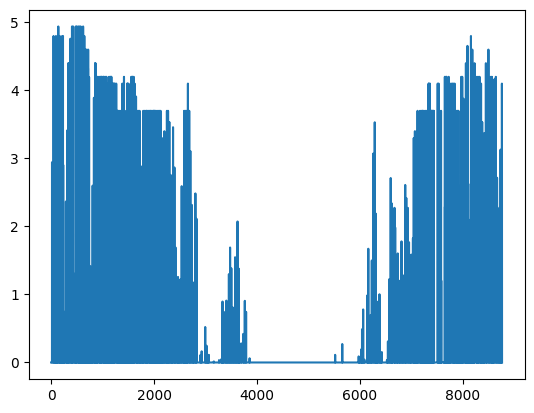

In [174]:
df2.E_batt_hp.plot()

In [151]:
df.E_demand.describe()

count    8760.000000
mean        0.419458
std         0.316674
min         0.090000
25%         0.090000
50%         0.342500
75%         0.713500
max         1.030000
Name: E_demand, dtype: float64

<Axes: >

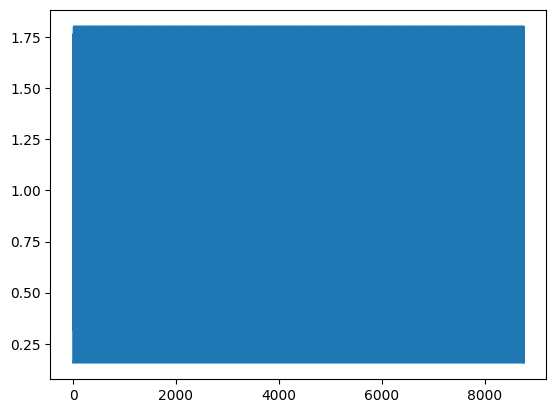

In [140]:
df.E_demand.plot()

In [135]:
df2.SOC.describe()

count    8760.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: SOC, dtype: float64

In [ ]:
TSS=(df2.E_PV_load+df2.E_PV_batt_EV+df2.E_PV_hp).sum()/(df2.E_EV_trip+df2.E_demand+df2.E_hp).sum()*100#[%]


In [133]:
TSS

np.float64(34.901479906444045)

In [144]:
output

,Building,Configuration,TSC [%],DSC [%],ISC [%],TSS [%],Demand_electric [kWh],Demand_thermal [kWh],Generation [kWh]
0,26930(Building-902138-CH895237183088),HP,26.5,26.5,0.0,32.8,5205.6,15468.1,17367.9
1,26930(Building-902138-CH895237183088),HP & BATT,34.2,16.2,18.0,28.5,5205.6,15468.1,17367.9
2,26931(Building-902142-CH963752308786),HP,27.8,27.8,0.0,25.6,2446.9,8776.9,6696.1
3,26931(Building-902142-CH963752308786),HP & BATT,36.4,17.0,19.5,22.7,2446.9,8776.9,6696.1
4,26932(Building-190183183-CH113098523737),HP,23.3,23.3,0.0,34.9,7043.0,19931.9,28405.3
5,26932(Building-190183183-CH113098523737),HP & BATT,30.2,14.2,16.0,30.9,7043.0,19931.9,28405.3
6,26933(Building-902139-CH503730975261),HP,30.2,30.2,0.0,34.2,7961.3,22212.3,22162.5
7,26933(Building-902139-CH503730975261),HP & BATT,38.7,19.7,19.0,29.8,7961.3,22212.3,22162.5
8,26934(Building-902141-CH513082523745),HP,26.9,26.9,0.0,32.3,4285.1,12436.0,13441.8
9,26934(Building-902141-CH513082523745),HP & BATT,34.7,16.6,18.1,28.1,4285.1,12436.0,13441.8


In [81]:
output.to_csv('output_zone0_valdebagnes.csv')

In [230]:
hp_table = output[output['Configuration'] == 'HP']
hp_batt_table = output[output['Configuration'] == 'HP & BATT']
hp_table.to_csv("HP_Configuration_Table.csv", index=False)
hp_batt_table.to_csv("HP_BATT_Configuration_Table.csv", index=False)



In [89]:
hp_table

,Building,Configuration,TSC [%],DSC [%],ISC [%],TSS [%],Demand_electric [kWh],Demand_thermal [kWh],Generation [kWh],Label,is_aggregated
0,26930(Building-902138-CH895237183088),HP,14.0,14.0,0.0,70.3,5205.6,15468.1,17367.9,26930(Building-902138-CH895237183088) - HP,False
2,26931(Building-902142-CH963752308786),HP,23.2,23.2,0.0,87.4,2446.9,8776.9,6696.1,26931(Building-902142-CH963752308786) - HP,False
4,26932(Building-190183183-CH113098523737),HP,9.4,9.4,0.0,56.7,7043.0,19931.9,28405.3,26932(Building-190183183-CH113098523737) - HP,False
6,26933(Building-902139-CH503730975261),HP,12.1,12.1,0.0,49.2,7961.3,22212.3,22162.5,26933(Building-902139-CH503730975261) - HP,False
8,26934(Building-902141-CH513082523745),HP,16.8,16.8,0.0,75.4,4285.0,12436.0,13441.8,26934(Building-902141-CH513082523745) - HP,False
10,Aggregated,HP,13.2,13.2,0.0,62.4,26941.8,78825.2,88073.7,Aggregated - HP,True


In [90]:
hp_batt_table

,Building,Configuration,TSC [%],DSC [%],ISC [%],TSS [%],Demand_electric [kWh],Demand_thermal [kWh],Generation [kWh],Label,is_aggregated
1,26930(Building-902138-CH895237183088),HP & BATT,17.4,13.1,4.2,78.2,5205.6,15468.1,17367.9,26930(Building-902138-CH895237183088) - HP & BATT,False
3,26931(Building-902142-CH963752308786),HP & BATT,30.3,18.2,12.1,92.6,2446.9,8776.9,6696.1,26931(Building-902142-CH963752308786) - HP & BATT,False
5,26932(Building-190183183-CH113098523737),HP & BATT,11.1,9.2,2.0,61.4,7043.0,19931.9,28405.3,26932(Building-190183183-CH113098523737) - HP ...,False
7,26933(Building-902139-CH503730975261),HP & BATT,14.1,11.8,2.3,52.3,7961.3,22212.3,22162.5,26933(Building-902139-CH503730975261) - HP & BATT,False
9,26934(Building-902141-CH513082523745),HP & BATT,21.6,15.3,6.2,85.6,4285.0,12436.0,13441.8,26934(Building-902141-CH513082523745) - HP & BATT,False
11,Aggregated,HP & BATT,16.1,12.2,3.9,67.3,26941.8,78825.2,88073.7,Aggregated - HP & BATT,True


In [50]:
output = pd.DataFrame(rows)


In [92]:
filename_prices=Path('../Input/Prices_2017.csv')

fields_prices=['index', 'Price_flat', 'Price_DT', 'Export_price', 'Price_flat_mod',
'Price_DT_mod']
df_prices=pd.read_csv(filename_prices,engine='python',sep=',|;',index_col=[0],
                    parse_dates=[0],usecols=fields_prices)

In [93]:
df_prices.head()

,Price_flat,Price_DT,Export_price,Price_flat_mod,Price_DT_mod
index,,,,,
2017-01-01 00:00:00+01:00,0.29,0.1646,0.05704,0.1716,0.130034
2017-01-01 00:15:00+01:00,0.29,0.1646,0.05704,0.1716,0.130034
2017-01-01 00:30:00+01:00,0.29,0.1646,0.05704,0.1716,0.130034
2017-01-01 00:45:00+01:00,0.29,0.1646,0.05704,0.1716,0.130034
2017-01-01 01:00:00+01:00,0.29,0.1646,0.05194,0.1716,0.130034


In [94]:
df_prices.describe()

,Price_flat,Price_DT,Export_price,Price_flat_mod,Price_DT_mod
count,35040.00,35040.000000,35040.000000,3.504000e+04,35040.000000
mean,0.29,0.216216,0.046001,1.716000e-01,0.170811
std,0.00,0.046884,0.019596,5.551194e-17,0.037038
min,0.29,0.164600,-0.049950,1.716000e-01,0.130034
25%,0.29,0.164600,0.033127,1.716000e-01,0.130034
50%,0.29,0.258800,0.041250,1.716000e-01,0.204452
75%,0.29,0.258800,0.055972,1.716000e-01,0.204452
max,0.29,0.258800,0.179920,1.716000e-01,0.204452


In [45]:
df.Req_kWh_DHW.sum()

np.float64(3682.1997199999946)

In [34]:
rows

[{'building': 'Building-902141-CH513082523745',
  'Configuration': '1100',
  'TSC': np.float64(21.5598616874538),
  'DSC': np.float64(15.326567201944762),
  'ISC': np.float64(6.233294485509036)}]

In [32]:
building_id

'Building-902141-CH513082523745'

In [31]:
output

,building,Configuration,TSC,DSC,ISC


In [13]:
df.columns

Index(['index', 'Bool_char', 'Bool_char_EV', 'Bool_cons', 'Bool_dis',
       'Bool_dis_EV', 'Bool_hp', 'Bool_hpdhw', 'Bool_inj', 'E_PV_batt',
       'E_PV_batt_EV', 'E_PV_bu', 'E_PV_budhw', 'E_PV_curt', 'E_PV_grid',
       'E_PV_hp', 'E_PV_hpdhw', 'E_PV_load', 'E_batt_EV_grid',
       'E_batt_EV_load', 'E_batt_bu', 'E_batt_budhw', 'E_batt_hp',
       'E_batt_hpdhw', 'E_batt_load', 'E_bu', 'E_budhw', 'E_char', 'E_char_EV',
       'E_char_away', 'E_cons', 'E_dis', 'E_dis_EV', 'E_grid_batt',
       'E_grid_batt_EV', 'E_grid_bu', 'E_grid_budhw', 'E_grid_hp',
       'E_grid_hpdhw', 'E_grid_load', 'E_hp', 'E_hpdhw', 'E_loss_Batt',
       'E_loss_Batt_EV', 'E_loss_EV', 'E_loss_conv', 'E_loss_inv',
       'E_loss_inv_PV', 'E_loss_inv_batt', 'E_loss_inv_grid', 'Q_dhwst_hd',
       'Q_hp_sh', 'Q_hp_ts', 'Q_loss_dhwst', 'Q_loss_ts', 'Q_ts', 'Q_ts_delta',
       'Q_ts_sh', 'SOC', 'SOC_EV', 'T_dhwst', 'T_ts', 'E_demand', 'E_PV',
       'Export_price', 'price', 'Inv_P', 'Conv_P'],
      dtype='objec